In the previous post, I showed how to solve inverse problems for coefficients of elliptic PDE using [firedrake-adjoint](http://www.dolfin-adjoint.org/en/latest/).
The exact parameter field that I used in that demonstration was smooth in space and, to guarantee a smooth solution, I showed how to add regularization to the objective functional.
Many geophysical inverse problems aim to estimate fields that instead have sharp discontinuities or interfaces.
For example, the porosity of soil and hard bedrock are very different and there is no continuous transition between the two.
For these media, the regularization functional

$$R(q) = \frac{1}{2}\int_\Omega|\nabla q|^2 dx$$

that we used in that demonstration would yield an infinite value.
The inferred field with this penalty would have a more diffuse interface than the real one.

Rather than use the integrated square gradient, we can instead use the **total variation** functional:

$$R(q) = \int_\Omega|\nabla q|dx.$$

We can get some insight into why the total variation is a good regularizer for these types of problems by using the very wonderful [coarea formula](https://en.wikipedia.org/wiki/Coarea_formula).
The coarea formula states that, for reasonable functions $p$ and $q$, we can express certain integrals involving the gradient of $q$ in terms of its contours or level sets.
Let $ds$ be the element of surface area, let $z$ be an arbitrary real value, and let $\Gamma_z$ be the $z$-contour surface of the function $q$.
Then

$$\int_\Omega p|\nabla q|dx = \int_{-\infty}^\infty\int_{\Gamma_z}p\, ds\, dz.$$

The right-hand side of the last equation can make sense even when $q$ is discontinuous, provided we're a little careful in the definition of the $z$-contour of $q$:

$$\Gamma_z = \partial\{x \in \Omega: q(x) \le z\}.$$

For example, suppose that $\Gamma$ is some nice closed surface inside $\Omega$, and we take $q$ to be equal to $\alpha$ in the interior of $\Gamma$ and $0$ outside.
Then the coarea formula tells us that

$$\int_\Omega|\nabla q|dx = a\cdot|\Gamma|.$$

This partly explains why the total variation functional is an effective regularizer.
While it doesn't forbid a jump discontinuity as such, it instead penalizes (1) the magnitude of the jump and (2) the area of the surface over which it occurs.
Gabriel Peyré has a nice visualization of the coarea formula on [Twitter](https://twitter.com/gabrielpeyre/status/985768327246237697).

### Calculating total variation

A new difficulty that we'll encounter here is that the total variation functional doesn't have a well-defined functional derivative like the mean square gradient does.
It is a convex functional, so the minimum is well-defined, but we might be at a loss for an algorithm to actually approximate it.

We've already encountered the mathematical concepts that we'll need to remedy this issue in a previous post on the obstacle problem.
The obstacle problem is the prototypical example of an optimization problem with inequality constraints.
To solve it, we reformulated the obstacle problem as an unconstrained convex optimization problem where the objective could take the value $+\infty$.
We then smoothed away the infinite values by instead working with the Moreau envelope of that functional.

Many of the same tricks work for total variation-type problems because the Moreau envelope of the $L^1$-norm has a simple analytical expression in terms of the *Huber function*:

$$H_\gamma(z) = \begin{cases}\frac{1}{2\gamma}|z|^2 & |z| < \gamma \\ |z| - \frac{\gamma}{2} & |z| \ge \gamma \end{cases}$$

The Huber function looks like the $L^1$ norm for large values of the argument, but like the square norm for small values.

In [1]:
import numpy as np
zs = np.linspace(-5., 5., 41)
γ = 2.
H_γ = [z**2 / (2 * γ) if abs(z) < γ else abs(z) - γ / 2 for z in zs]

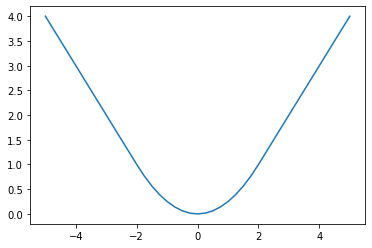

In [2]:
import matplotlib.pyplot as plt
plt.plot(zs, H_γ);

The Moreau envelope of the 1-norm can be expressed through the Huber function.
Suppose that $z$ and $w$ are vector fields in the space $L^2(\Omega)$; then

$$\inf_w\left(\int_\Omega|w|dx + \frac{1}{2\gamma}\int_\Omega|z - w|^2dx\right) = \int_\Omega H_\gamma(z)dx.$$

This Huber functional does have a well-defined functional derivative for positive values of the penalty parameter $\gamma$, so we can reuse our old gradient-based optimization routines.
As with any penalty-type method, however, the problem becomes more ill-conditioned as we decrease $\gamma$.
There's one more critical fact we'll need.
We know how to calculate the Moreau envelope of the 1-norm, but our regularization functional is instead a scalar multiple of the 1-norm.
If we denote the envelope of a functional $R$ by $\text{env}_\gamma R$, then

$$\text{env}_\gamma\, \alpha\cdot R = \alpha\cdot\text{env}_{\gamma\alpha}R.$$

With this identity in hand, we can instead try to minimize the approximate objective functional

$$J_\gamma(u, q) = \frac{1}{2}\int_\Omega\left(\frac{u - u^o}{\sigma}\right)^2dx + \alpha\int_\Omega H_{\alpha\gamma}\left(\nabla q\right)\,dx.$$

Letting $F$ be the weak form of the Poisson equation, our constraint is that

$$\langle F(u, q), v\rangle = 0$$

for all test functions $v$.
Recall that the scalar parameter $\alpha$ that dictates the degree to which we're regularizing the problem, and has units of $[q]^{-1}\cdot[x]$.
When we were using the mean square gradient to regularize the problem, this quantity was raised to the power 2 to make the units work out correctly.
Here the exponent is 1 instead.
Moreover, we can make an educated guess for what $\alpha$ might be if we know roughly the numerical range of the field we're inferring and the diameter of the domain.

### Generating the exact data

We'll proceed much like we did in the last post, only the conductivity field will have a sharp interface such as one might find between two distinct media.
To make things a little easier later, we'll actually use a continuous Galerkin basis, in which case the interface will extend over a single grid cell.
This is a little bit sinful and really we should be using a DG basis.
But that would involve a bunch of annoying facet integrals that distract from the real point.
We can just as easily illustrate the essential idea using continuous basis functions.

In [3]:
import firedrake
mesh = firedrake.UnitSquareMesh(32, 32, diagonal='crossed')
Q = firedrake.FunctionSpace(mesh, family='CG', degree=2)
V = firedrake.FunctionSpace(mesh, family='CG', degree=2)

In [4]:
from numpy import random, pi as π
x = firedrake.SpatialCoordinate(mesh)

rng = random.default_rng(seed=1)
def random_fourier_series(std_dev, num_modes, exponent):
    from firedrake import sin, cos
    A = std_dev * rng.standard_normal((num_modes, num_modes))
    B = std_dev * rng.standard_normal((num_modes, num_modes))
    return sum([(A[k, l] * sin(π * (k * x[0] + l * x[1])) +
                 B[k, l] * cos(π * (k * x[0] + l * x[1])))
                / (1 + (k**2 + l**2)**(exponent/2))
                for k in range(num_modes)
                for l in range(int(np.sqrt(num_modes**2 - k**2)))])

In [5]:
from firedrake import interpolate, project
g = interpolate(random_fourier_series(1.0, 6, 1), V)

In [6]:
from firedrake import inner, max_value, conditional, Constant
a = -Constant(4.5)
r = Constant(1/4)
ξ = Constant((0.4, 0.5))
q_true = interpolate(a * conditional(inner(x - ξ, x - ξ) < r**2, 1, 0), Q)

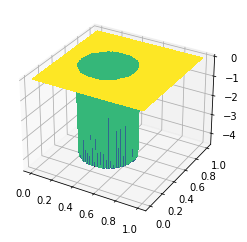

In [7]:
firedrake.trisurf(q_true);

In [8]:
b = Constant(6.)
R = Constant(1/4)
η = Constant((0.7, 0.5))
f = interpolate(b * max_value(0, 1 - inner(x - η, x - η) / R**2), V)

In [9]:
from firedrake import exp, grad, dx, ds
k = Constant(1.)
h = Constant(10.)
u_true = firedrake.Function(V)
v = firedrake.TestFunction(V)
F = (
    (k * exp(q_true) * inner(grad(u_true), grad(v)) - f * v) * dx +
    h * (u_true - g) * v * ds
)

In [10]:
opts = {
    'solver_parameters': {
        'ksp_type': 'preonly',
        'pc_type': 'lu',
        'pc_factor_mat_solver_type': 'mumps'
    }
}
firedrake.solve(F == 0, u_true, **opts)

The true solution shares many properties with that of the previous demo, namely the sharp spike in the middle of the domain where the medium becomes more insulating.
An interesting feature you can see here is how there's a break in slope across the discontinuity.
This is a general feature of sharp interface problems; the flux is discontinuous, even though the gradient of the solution is not.

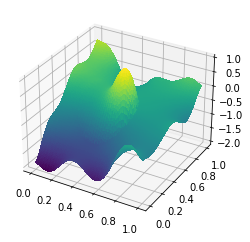

In [11]:
firedrake.trisurf(u_true);

### Generating the observational data

To create the synthetic observations, we'll proceed along the same lines as in the last post.
Recall that these incantations were necessary because generating a random field with the correct error statistics using a finite element basis does all sorts of weird unintuitive things.

In [12]:
ξ = firedrake.Function(V)
n = len(ξ.dat.data_ro)
ξ.dat.data[:] = rng.standard_normal(n)

In [13]:
from firedrake import assemble, PETSc
ϕ, ψ = firedrake.TrialFunction(V), firedrake.TestFunction(V)
m = inner(ϕ, ψ) * dx
M = assemble(m, mat_type='aij').M.handle
ksp = PETSc.KSP().create()
ksp.setOperators(M)
ksp.setUp()
pc = ksp.pc
pc.setType(pc.Type.CHOLESKY)
pc.setFactorSolverType(PETSc.Mat.SolverType.PETSC)
pc.setFactorSetUpSolverType()
L = pc.getFactorMatrix()
pc.setUp()

In [14]:
area = assemble(Constant(1) * dx(mesh))

In [15]:
z = firedrake.Function(V)
z.dat.data[:] = rng.standard_normal(n)
with z.dat.vec_ro as Z:
    with ξ.dat.vec as Ξ:
        L.solveBackward(Z, Ξ)
        Ξ *= np.sqrt(area / n)

In [16]:
û = u_true.dat.data_ro[:]
signal = û.max() - û.min()
signal_to_noise = 50
σ = firedrake.Constant(signal / signal_to_noise)

u_obs = u_true.copy(deepcopy=True)
u_obs += σ * ξ

### Solution via Moreau envelopes

We will again use the blunt initial guess that $q = 0$ everywhere.

In [17]:
import firedrake_adjoint

In [18]:
q = firedrake.Function(Q)
u = firedrake.Function(V)
F = (
    (k * exp(q) * inner(grad(u), grad(v)) - f * v) * dx +
    h * (u - g) * v * ds
)
firedrake.solve(F == 0, u, **opts)

Once again, the initial computed solution lacks the large spike in the insulating part of the medium.

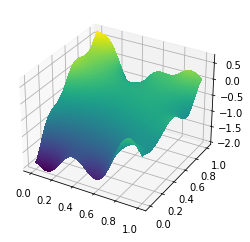

In [19]:
firedrake.trisurf(u);

The Huber functional is easy to express in UFL.
Before writing this, I tried to find a few different ways to express the Huber functional in a way that might be more amenable to symbolic differentiation because I thought that the conditional would prove to be a huge problem.
None of those worked out mathematically, but to my surprise, it seems as if Firedrake can still calculate functional derivatives of conditional expressions just fine.

In [20]:
from firedrake import sqrt
def huber(v, γ):
    return firedrake.conditional(
        inner(v, v) < γ**2,
        inner(v, v) / (2 * γ),
        sqrt(inner(v, v)) - γ / 2
    )

We'll use the same value $\alpha$ for the smoothing length as in the previous demo, noting again that it's to the power of 1 instead of 2 this time.
But we don't have much in the way of a priori guidance for how to pick the Moreau envelope parameter $\gamma$, which should be dimensionless.
I arrived at the following value by trial and error.

In [21]:
α = Constant(5e-2)
γ = Constant(4e2)

J = assemble(
    0.5 * ((u - u_obs) / σ)**2 * dx +
    α * huber(grad(q), α * γ) * dx
)

The procedure to compute the solution works just the same as before.

In [22]:
q̂ = firedrake_adjoint.Control(q)
Ĵ = firedrake_adjoint.ReducedFunctional(J, q̂)
q_γ = firedrake_adjoint.minimize(Ĵ)

The resulting approximation does a fairly good job capturing the sharp gradients in the inferred field around part of the interface.
On the upper left side, the jump has been blurred out, which is to be expected based on the form of the Huber approximation.

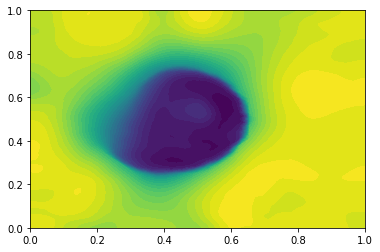

In [23]:
firedrake.tricontourf(q_γ, 40)

Finally, let's see how well our approximation matches the true value:

In [24]:
assemble(abs(q_true - q_γ) * dx) / assemble(abs(q_true) * dx)

0.4745209247267914

Next let's see what happens when we use a much smaller value of the envelope parameter.
If you run this code yourself, you can observe first-hand how the problem gets much more ill-conditioned as you decrease $\gamma$ by how much longer it takes to get a solution!

In [25]:
Γ = Constant(10)

J = assemble(
    0.5 * ((u - u_obs) / σ)**2 * dx +
    α * huber(grad(q), α * Γ) * dx
)

q̂ = firedrake_adjoint.Control(q)
Ĵ = firedrake_adjoint.ReducedFunctional(J, q̂)
q_Γ = firedrake_adjoint.minimize(Ĵ)

The resulting solution gives a substantially better fit to the true parameters.

In [26]:
assemble(abs(q_true - q_Γ) * dx) / assemble(abs(q_true) * dx)

0.2600467478473466

Moreover, the interface is noticeably much sharper when we decrease $\gamma$, as expected.

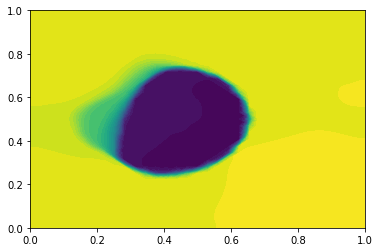

In [27]:
firedrake.tricontourf(q_Γ, 40)

At a few points, the mesh triangles have made themselves apparent.
To fix this, we would want to either adapt the mesh to the contours of $q$, or do things the blunt way and uniformly refine until this effect was no longer obvious.

### Discussion

Regularization of inverse problems is a subtle topic.
When the field we're inferring has sharp discontinuities, the total variation functional can be a better regularizer than the mean square gradient.
There's a statistical way to make that argument more precise: TV better represents the prior information that we're claiming to have about our solution.
Using it incurs a cost in implementation complexity, however, because the TV functional is non-smooth.
As with the obstacle problem, the Moreau envelope provides us with a way to solve non-smooth optimization problems using tools that were designed only for smooth ones.

We've examined what regularization functional to use here, but we haven't examined the topic of deciding how much to regularize.
There are several procedures for choosing a value of $\alpha$, some merely heuristic and others based on deeper insights from Bayesian statistical inference.
In the statistical literature this is often referred to as *hyperparameter optimization* and it's arguably just as important as deciding which regularization functional to use in the first place.